In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from matplotlib import cm
from matplotlib import gridspec
from mayavi import mlab
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

#Folders
projpath    = os.path.realpath("..")
pathvectors = os.path.join(projpath, "Results", "Vectors")
pathfacepca = os.path.join(projpath, "Results", "FacePCA")
pathmerged  = os.path.join(projpath, "Results", "MergedData")
pathdbases  = os.path.join(projpath, "DataBases")

#Read data
os.chdir(pathdbases)
ibd_fs = pd.read_csv("IBD_FS.csv", sep=",")

os.chdir(pathmerged)
mergeddat = pd.read_csv("MergedDat.csv", sep=",")

os.chdir(pathvectors)
sex_vectors = pd.read_csv("sex_vectors.csv", sep=",")

os.chdir(pathfacepca)
eigenvectors = pd.read_csv("eigenvectors.csv", sep=",", header=None)
means        = pd.read_csv("means.csv", sep=",", header=None)
facets       = pd.read_csv("facets.csv", sep=",", header=None)

#Getting landmarks from PCA scores
sex_landmarks = ( ( np.matrix(sex_vectors.iloc[:,0:35]) * 1)  * np.matrix(eigenvectors).transpose() ) + np.matrix(means).transpose()

#Getting landmarks for extreme PCs
PCs = np.zeros([4,35])
PCs[0][0] = (mergeddat.std()*3)[0]
PCs[1][0] = -(mergeddat.std()*3)[0]
PCs[2][1] = (mergeddat.std()*3)[1]
PCs[3][1] = -(mergeddat.std()*3)[1]
PCs_landmarks = ( np.matrix(PCs) * np.matrix(eigenvectors).transpose() ) + np.matrix(means).transpose()
avg_landmarks = (np.matrix(np.zeros(35)) * np.matrix(eigenvectors).transpose() ) + np.matrix(means).transpose()


In [2]:
###############DEFINE FUNCTIONS#############
def take_screenshot(landmarks, facets, profile = 0, colormap = None ):
    '''
    Take screenshot of rendered 3D face
    Usage
        Input:
            - landmarks: set of 3D landmarks in one single row, in X,Y,Z consecutive fashion
            - facets: the facets that describe the surface from the 3D landmarks
            - profile: whether to take the screenshot from frontal or profile (0/1)
            - colormap: the colormap to be applied to the 3D surface to the scalar argument
        Output:
            - screenshot: np array of 2D picture
    '''
    #Importing required libraries
    import numpy as np
    import pandas as pd
    from mayavi import mlab

    #Setting offscreen rendering, figure, and X,Y,Z objects
    mlab.options.offscreen = True #True or False
    myfig = mlab.figure(bgcolor=(1, 1, 1), size=(2000, 1750)) 
    face  = landmarks.reshape(7160, 3)
    X = np.array(face[:,0]).flatten()
    Y = np.array(face[:,1]).flatten()
    Z = np.array(face[:,2]).flatten()
    
    #Generating the mesh, depending on whether colormap is supplied
    if colormap is None:
        mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='surface', figure = myfig, color=(0.7,0.7,0.7) )
    elif colormap is not None:
        mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='surface', figure = myfig, scalars=colormap, colormap='GnBu' )
    
    #Setting mesh properties
    mesh.actor.property.backface_culling = True
    mesh.scene.anti_aliasing_frames = 20
    mesh.scene.camera.compute_view_plane_normal()
    
    #Setting camera
    if profile == 1:
        mesh.scene.camera.position = [-0.082, -0.014, 0.0033]
        mesh.scene.camera.view_up  = [-0.12, 0.81, 0.58]
    elif profile == 0:
        mesh.scene.camera.position = [-0.005, -0.037, 0.067]
        mesh.scene.camera.view_up  = [-0.05, 1, 0.5]
        
    #Taking screenshot
    screenshot = mlab.screenshot(myfig, mode='rgba', antialiased=True)
    #Set the white background with an alpha of 0, that is, transparent
    screenshot[ np.all(screenshot == 1, axis=2) ] = 0 
    mlab.close()
    return(screenshot)

def get_euc_dist(landmark1, landmark2):
    '''
    Get the Euclidean distances between to set of 3D landmarks
    Usage
        Input:
            - landmark1 and landmark2: set of 3D landmarks in one single row, in X,Y,Z consecutive fashion, to compute the distances from
        Output:
            - euc_dist: euclidean distance between corresponding set of 3D landmarks
    '''
    #Importing libraries
    import numpy as np
    import pandas as pd
    
    #Setting number of landmarks
    n_landmarks = int(landmark1.shape[1] / 3)
    
    #Reshaping landmarks
    face1 = landmark1.reshape(n_landmarks, 3)
    face2 = landmark2.reshape(n_landmarks, 3)
    #Calculating euclidean distance
    euc_dist = np.array(np.sqrt(np.sum(np.power(face1 - face2, 2), axis=1))).flatten()
    return(euc_dist)

def paste_screenshot(landmarks, facets, pos = (0,0)):
    face = take_screenshot(landmarks, facets)
    image = OffsetImage(face, zoom=0.05)
    ab = AnnotationBbox(image, pos, xycoords='data', frameon=False)
    ax.add_artist(ab)
    
def scatter_gm(x, y, group, nrow = 1, ncol = 1, index = 1, ticks = 1, xlim = [-0.1, 0.1], ylim = [-0.1, 0.1], means = 0):
    '''
    Generate geometric morphometrics like scatter plot, with axes going through the origin using different colors for groups.
    This function generates an ax object, make sure to have your figure (fig) object already called
    Usage
        Input:
            - x: values to be plotted in the x coordinates
            - y: values to be plotted in the y coordinates
            - group: grouping variable to be maped on the scatter plot
            - nrow: number of rows for subplot
            - ncol: number of columns for subplot
            - index: index to be used by subplot
            - ticks: whether to maintain the default ticks (0), or use one from -0.1 to 0.1 (1)
            - xlim: the limits of x axis
            - ylim: the limits of y axis
            - means: whether mean values of the group variable are to be highlighted (0/1)
        Output:
            - ax: ax matplotlib object
    '''
    #Importing required libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    ax    = fig.add_subplot(nrow, ncol, index)
    color = group.map(color_map)
    if means == 0:
        al = 0.5
    elif means == 1:
        al = 0.2
        mean_male = [x[group=="Male"].mean(), y[group=="Male"].mean()]
        mean_female = [x[group=="Female"].mean(), y[group=="Female"].mean()]

    ax.scatter(x, y, alpha = al, c=color )
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    
    if means == 1:
        ax.scatter(mean_female[0], mean_female[1], c = color_map['Female'], s=100, edgecolors='black' )
        ax.scatter(mean_male[0], mean_male[1], c = color_map['Male'], s=100, edgecolors='black' )
    
    if ticks == 1:
        plt.xticks([-0.1, -0.05, 0.05, 0.1])
        plt.yticks([-0.1, -0.05, 0.05, 0.1])
    elif ticks == 0:
        plt.xticks([])
        plt.yticks([])
        
    return(ax)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

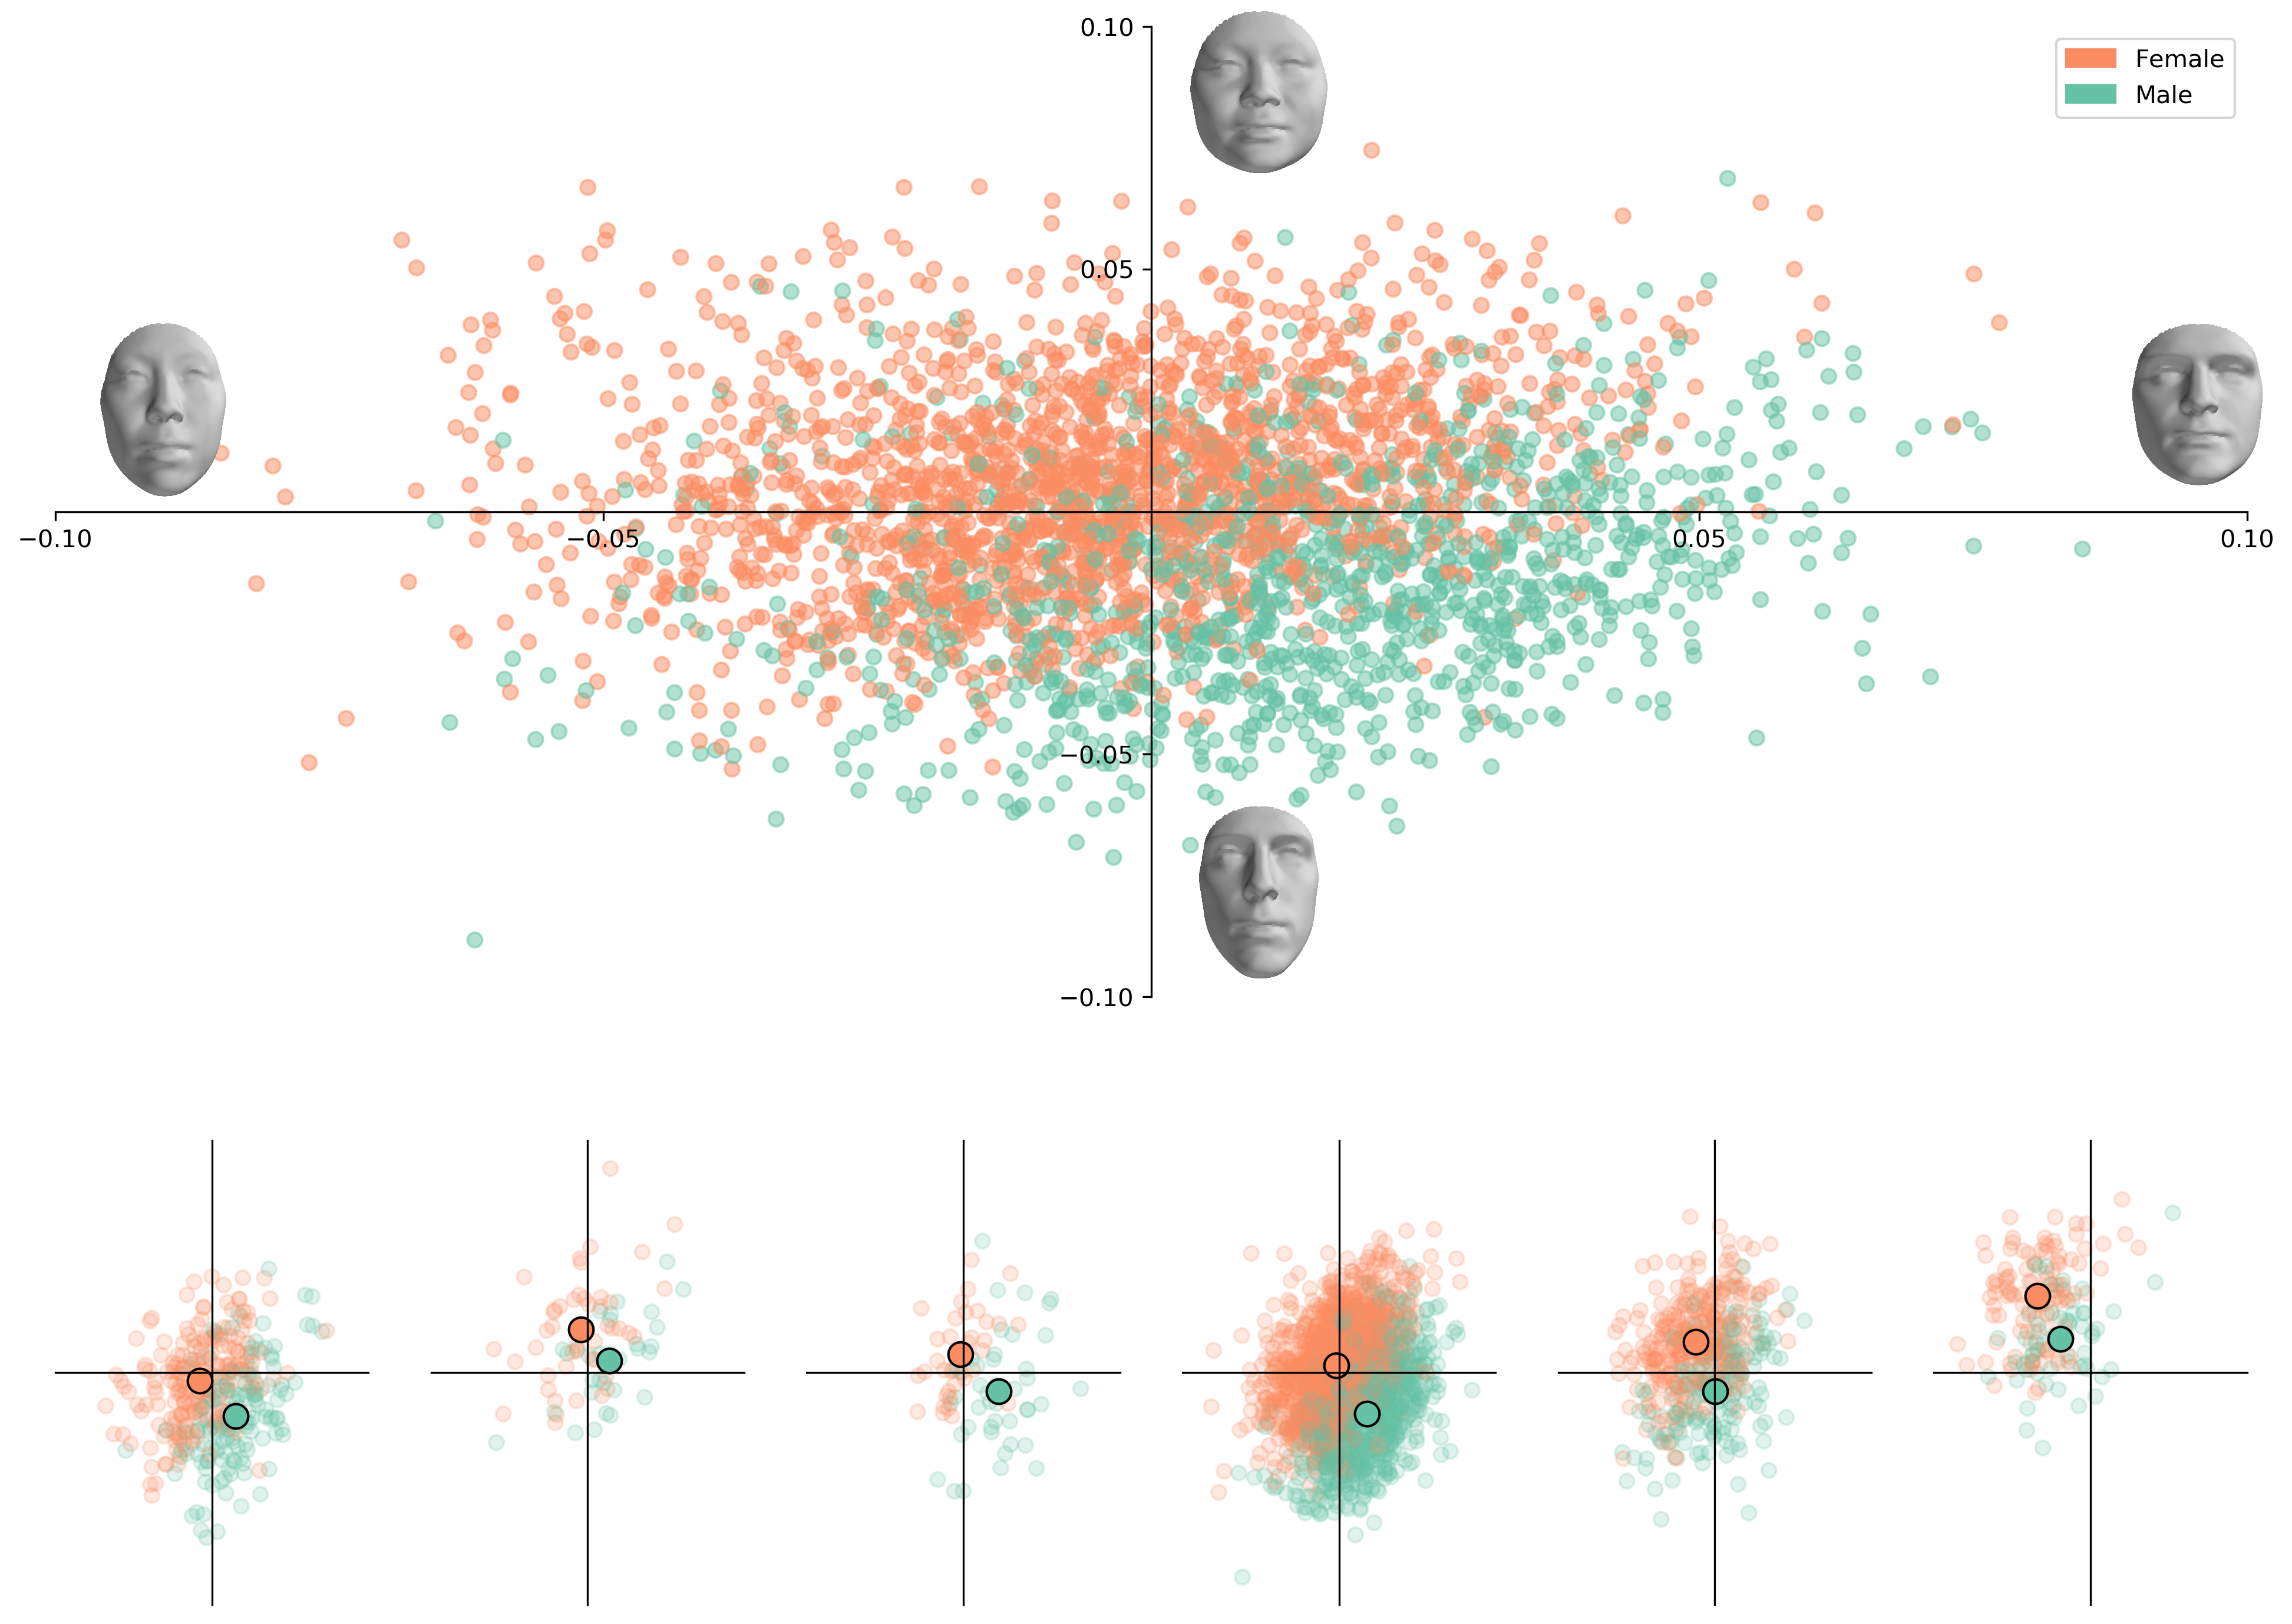

In [7]:
##### FIGURE 1 #####
#Scatter plot with PC scores and projected faces on top
#NEED TO ADD SEX_VECTOR ESTIMATION INSTEAD OF THE AVERAGE!!
PC1 = mergeddat["FacePC1"]
PC2 = mergeddat["FacePC2"]
Sex = mergeddat["Sex"]

color_labels = Sex.unique()
rgb_values   = sns.color_palette("Set2", 2)
color_map    = dict(zip(color_labels, rgb_values))

fig = plt.figure(figsize=(16, 16), dpi=300)
ax  = scatter_gm(PC1, PC2, Sex, 2, 1, 1)

paste_screenshot(PCs_landmarks[0,:], facets, (0.0957, 0.02) )
paste_screenshot(PCs_landmarks[1,:], facets, (-0.09, 0.02) )
paste_screenshot(PCs_landmarks[2,:], facets, (0.01, 0.085) )
paste_screenshot(PCs_landmarks[3,:], facets, (0.01, -0.08) )

#Setting the legend
female_patch = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map["Female"], label='Female')
male_patch   = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map["Male"], label='Male')

plt.legend(handles=[female_patch, male_patch])

#Ploting small plots
for i in range(1,7):
    newPC1 = mergeddat[mergeddat['k6'] == i]['FacePC1'].reset_index(drop=True)
    newPC2 = mergeddat[mergeddat['k6'] == i]['FacePC2'].reset_index(drop=True)
    newSex = mergeddat[mergeddat['k6'] == i]['Sex'].reset_index(drop=True)
    index  = i + 12 
    scatter_gm(newPC1, newPC2, newSex, 4, 6, index, ticks=0, means=1) 
    
#plt.show() #show or save
plt.savefig("Figure1.png")

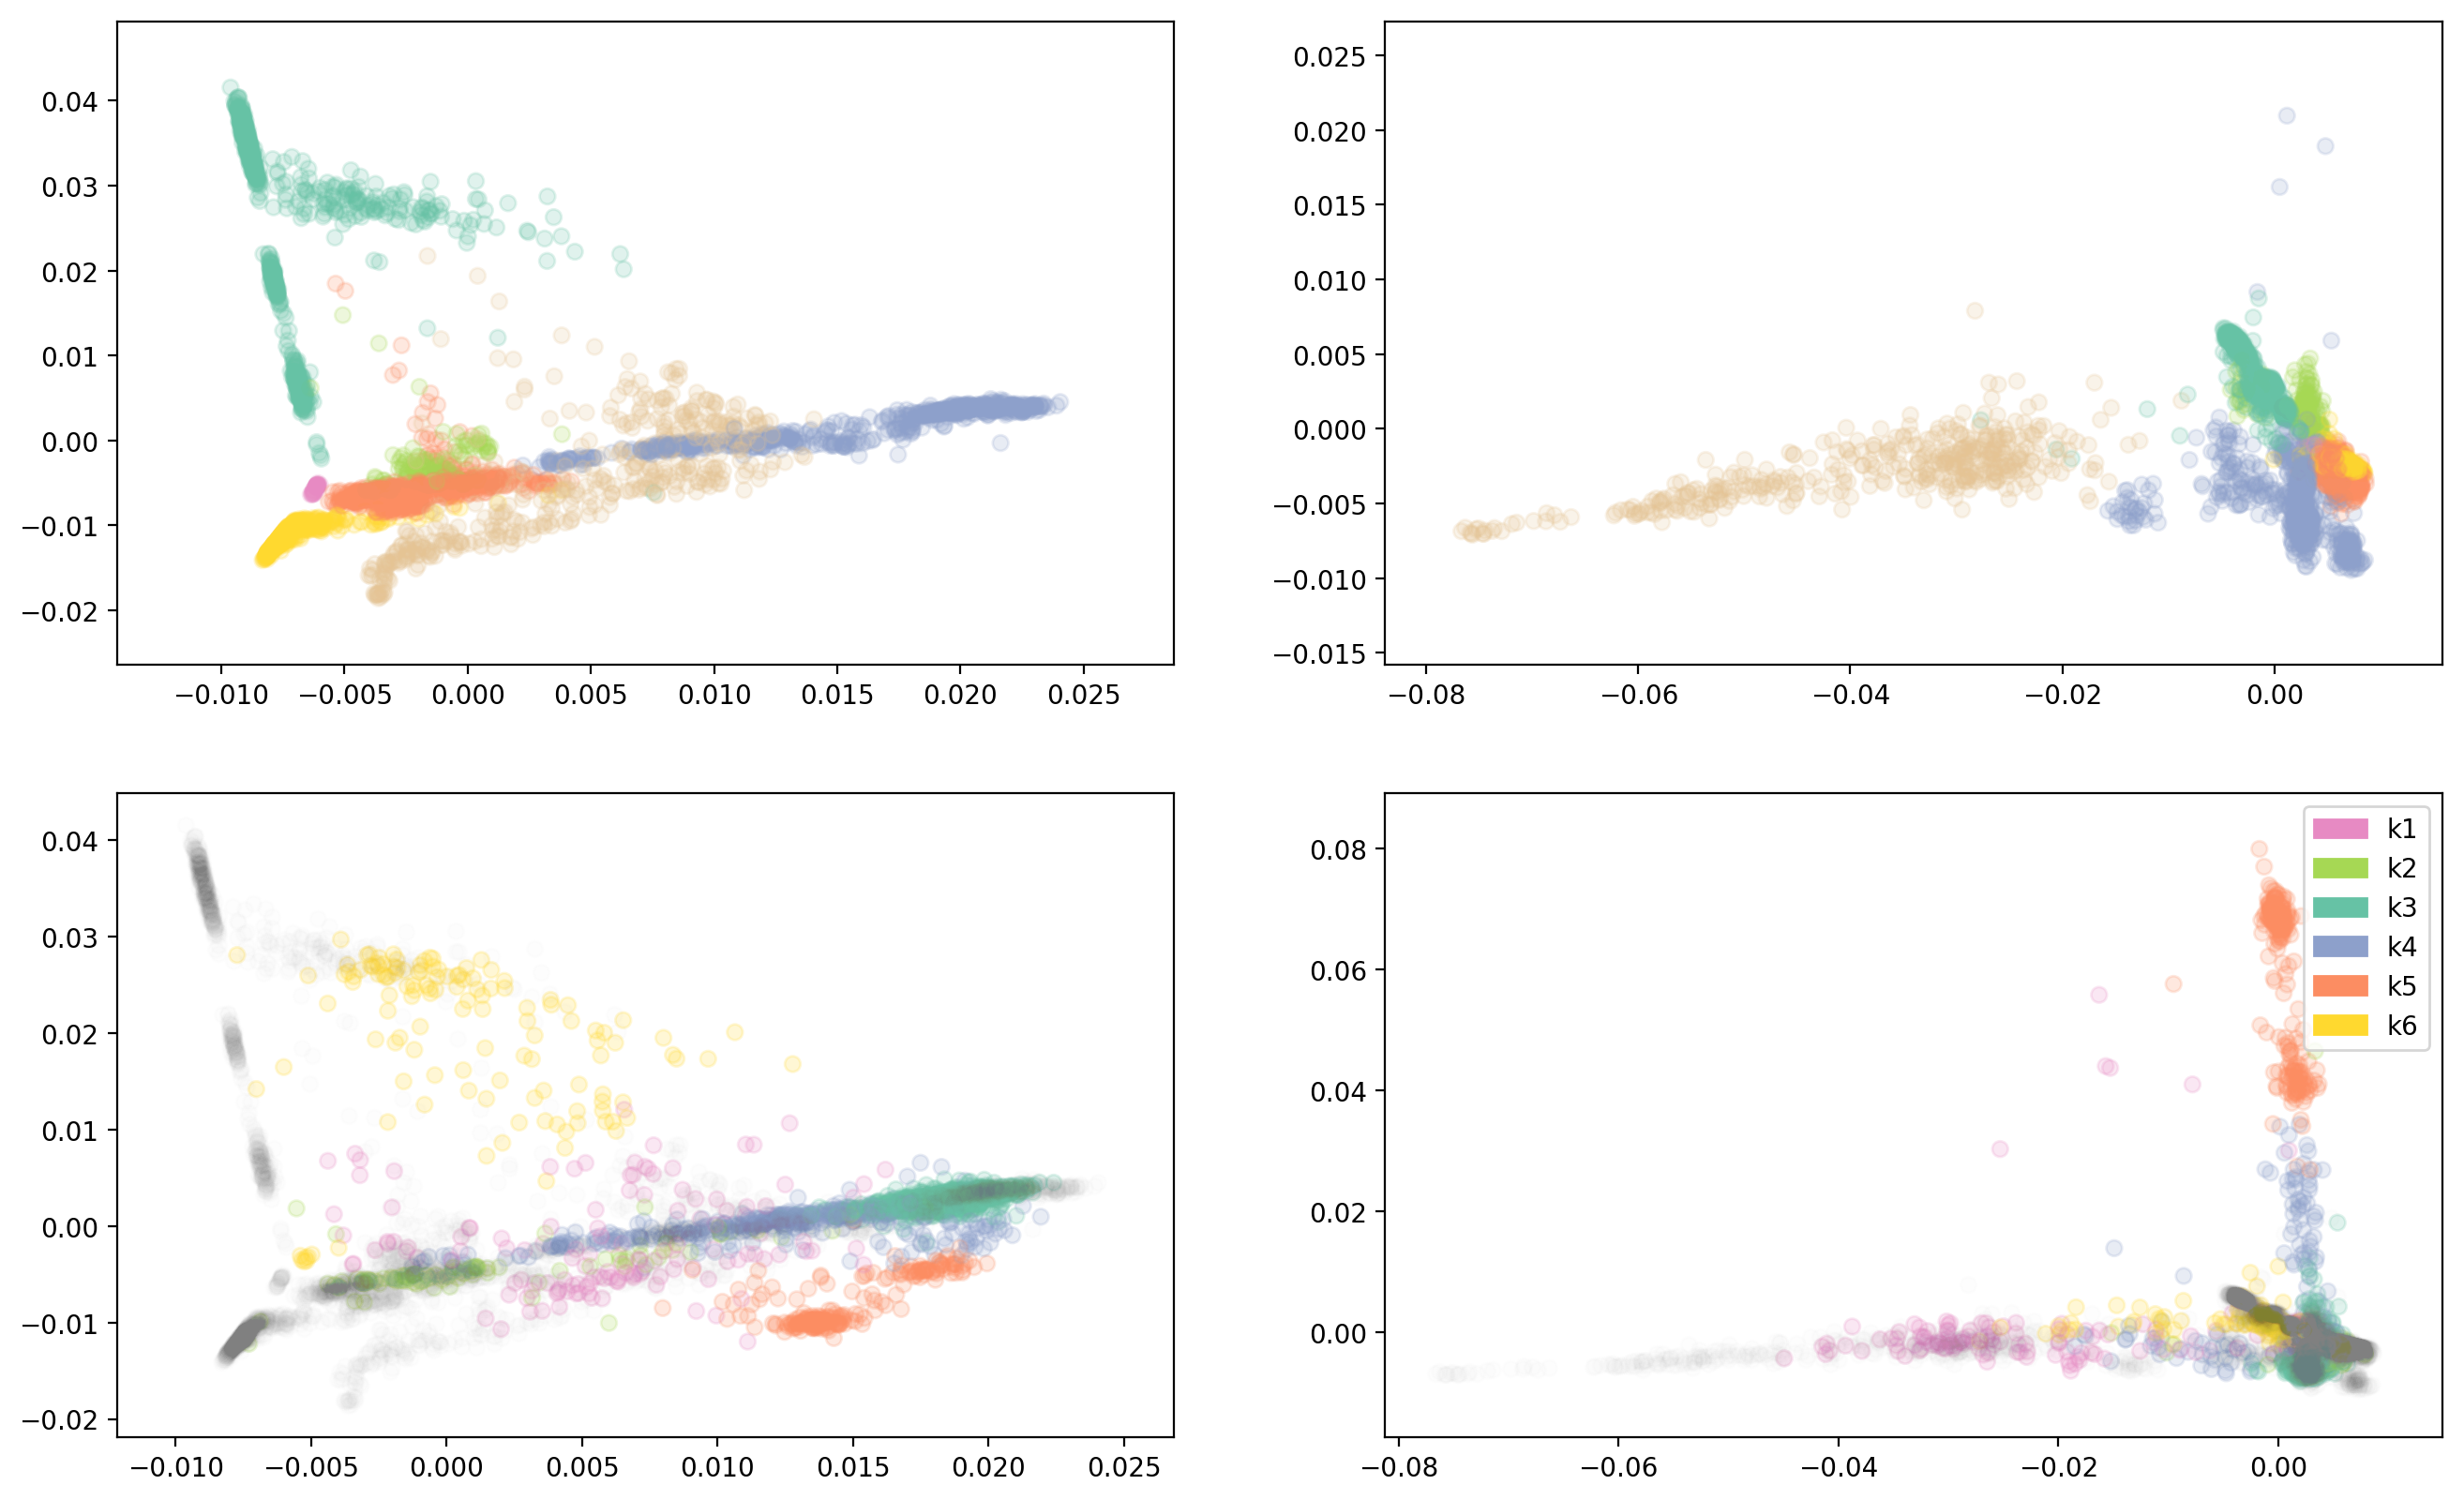

In [53]:
#FIGURE 2
#POP genetics?
#Plot reference super_pops
refPC1 = ibd_fs[ibd_fs['super_pop'] != 'ADAPT' ]['PC1'].reset_index(drop=True)
refPC2 = ibd_fs[ibd_fs['super_pop'] != 'ADAPT' ]['PC2'].reset_index(drop=True)
refPC3 = ibd_fs[ibd_fs['super_pop'] != 'ADAPT' ]['PC3'].reset_index(drop=True)
refPC4 = ibd_fs[ibd_fs['super_pop'] != 'ADAPT' ]['PC4'].reset_index(drop=True)
super_pop = ibd_fs[ibd_fs['super_pop'] != 'ADAPT' ]['super_pop'].reset_index(drop=True)

fig = plt.figure(figsize=(16, 10), dpi=200)
ax  = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

color_labels = super_pop.unique()
rgb_values   = sns.color_palette("Set2", 7)
color_map    = dict(zip(color_labels, rgb_values))

ax.scatter(refPC1, refPC2, c=super_pop.map(color_map), alpha=0.2 )
ax2.scatter(refPC3, refPC4, c=super_pop.map(color_map), alpha=0.2 )

#Legends 1
patch1 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['AFR'], label='AFR')
patch2 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['SAS'], label='SAS')
patch3 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['EUR'], label='EUR')
patch4 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['OCE'], label='OCE')
patch5 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['MDE'], label='MDE')
patch6 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['EAS'], label='EAS')
patch7 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map['AMR'], label='AMR')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6,patch7])

PC1 = mergeddat['PC1']
PC2 = mergeddat['PC2']
PC3 = mergeddat['PC3']
PC4 = mergeddat['PC4']
groups = mergeddat['k6'] 
color_labels = groups.unique()
rgb_values   = sns.color_palette("Set2", 7)
color_map    = dict(zip(color_labels, rgb_values))

ax3.scatter(PC1, PC2, c=groups.map(color_map), alpha=0.2)
ax3.scatter(refPC1, refPC2, alpha=0.01, c='grey')
ax4.scatter(PC3, PC4, c=groups.map(color_map), alpha=0.2)
ax4.scatter(refPC3, refPC4, alpha=0.01, c='grey')

#Legends 2
patch1 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[1], label='k1')
patch2 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[2], label='k2')
patch3 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[3], label='k3')
patch4 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[4], label='k4')
patch5 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[5], label='k5')
patch6 = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map[6], label='k6')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])

plt.show()


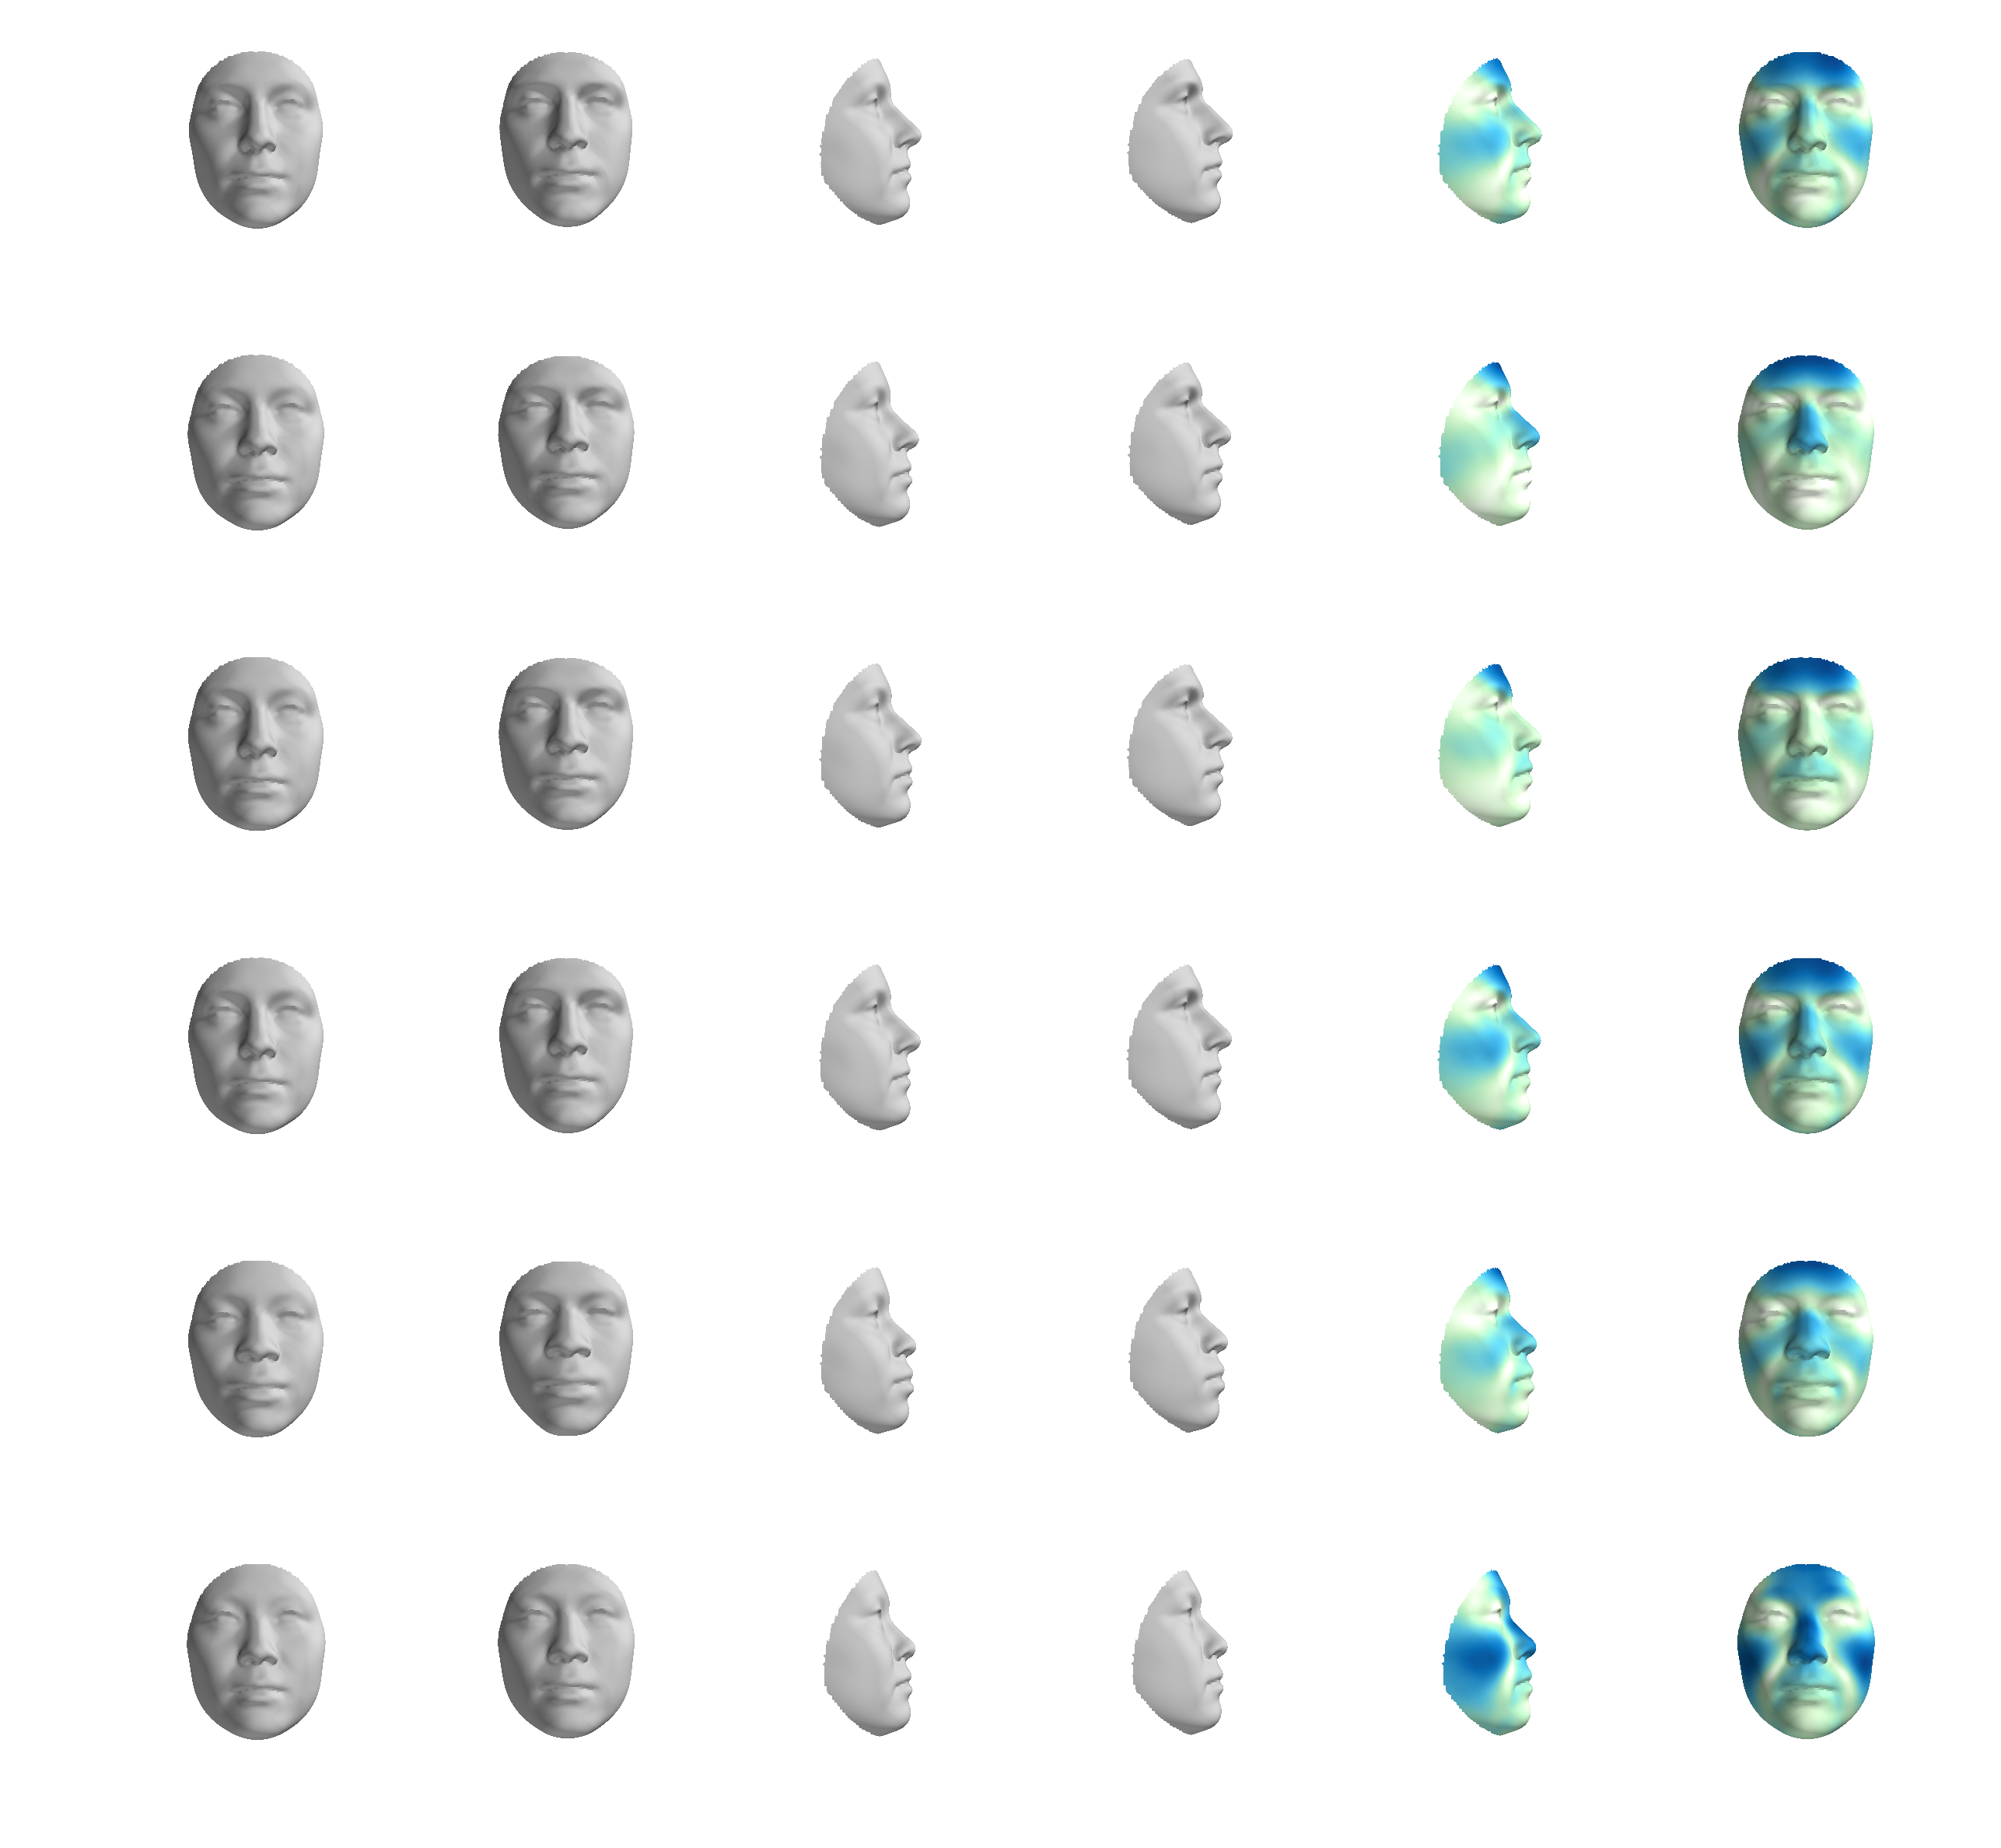

In [8]:
#FIGURE 3
#Plot of sex average faces, and their difference
from matplotlib import gridspec
nrow = 6
ncol = 6

fig   = plt.figure(figsize=(10, 10), dpi=300)
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

index = 1 
for i in range(6):
    face1 = sex_landmarks[i]
    face2 = sex_landmarks[i+6]
    ax1   = fig.add_subplot(nrow,ncol,index)
    index = index + 1 
    plt.axis('off')
    ax2   = fig.add_subplot(nrow,ncol,index)
    index = index + 1
    plt.axis('off')
    ax3   = fig.add_subplot(nrow,ncol,index)
    index = index + 1
    plt.axis('off')
    ax4   = fig.add_subplot(nrow,ncol,index)
    index = index + 1
    plt.axis('off')
    ax5   = fig.add_subplot(nrow,ncol,index)
    index = index + 1
    plt.axis('off')
    ax6   = fig.add_subplot(nrow,ncol,index)
    index = index + 1
    plt.axis('off')
    img1 = take_screenshot(face1, facets)
    img2 = take_screenshot(face2, facets)
    img3 = take_screenshot(face1, facets, profile=1)
    img4 = take_screenshot(face2, facets, profile=1)
    dist  = get_euc_dist(face1, face2)
    avg   = sum(face1, face2) / 2
    img5 = take_screenshot(avg, facets, colormap=dist, profile=1)
    img6 = take_screenshot(avg, facets, colormap=dist)
    ax1.imshow(img1)
    ax2.imshow(img2)
    ax3.imshow(img3)
    ax4.imshow(img4)
    ax5.imshow(img5)
    ax6.imshow(img6)

#plt.show() #show or save
plt.savefig("Figure2.png")

In [50]:
#Getting normal displacement between faces
face_fem  = sex_landmarks[0,:].reshape(7160, 3)
face_male = sex_landmarks[3,:].reshape(7160, 3)
dist = np.array(np.sqrt(np.sum(np.power(face_fem - face_male, 2), axis=1))).flatten()



In [139]:
print(face_fem[0], face_male[0])
x = np.array(face_fem[:,0]).flatten()
y = np.array(face_fem[:,1]).flatten()
z = np.array(face_fem[:,2]).flatten()
u = np.array(face_fem[0:2] - face_male[0:2])[:,0]
v = np.array(face_fem[0:2] - face_male[0:2])[:,1]
w = np.array(face_fem[0:2] - face_male[0:2])[:,2]
x2 = np.array(face_male[0:1,0]).flatten()
y2 = np.array(face_male[0:1,1]).flatten()
z2 = np.array(face_male[0:1,2]).flatten()
#deltas = face_fem - face_male

#Getting angles
#magA = np.sqrt(np.dot(face_fem,face_fem))
#magB = np.sqrt(np.dot(face_male,face_male))
#angles = np.arccos(np.dot(face_fem,face_male)/(magA*magB))

mlab.plot3d(np.array([[1,2],[2,3]]), np.array([[2,5][-1,0]]), np.array([[5,6],[7,8]]), tube_radius=10.)
#mlab.plot3d(x,y,z)
mlab.show()

[[-0.01346761  0.00580962 -0.00596736]] [[-0.01333852  0.00622649 -0.00659419]]


TypeError: list indices must be integers or slices, not tuple

In [132]:
n_mer, n_long = 6, 11
dphi = np.pi / 1000.0
phi = np.arange(0.0, 2 * np.pi + 0.5 * dphi, dphi)
mu = phi * n_mer
x = np.cos(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
y = np.sin(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
z = np.sin(n_long * mu / n_mer) * 0.5
mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
mlab.show()

In [83]:
x = np.array([1.,2.,3.])
y = np.array([0.,0.,0.])
z = y

phi   = np.linspace(0,np.pi/2.0,3)
theta = phi

u = np.sin(theta) * np.cos(phi)
v = np.sin(theta) * np.sin(phi)
w = np.cos(theta)

In [9]:
#Testing for comparing two shapes


#FOR EUCLIDEAN DISTANCE
myfig = mlab.figure(1, fgcolor=(0.5, 0.5, 0.5), bgcolor=(1, 1, 1),  size=(2000, 1750))
    
face1 = sex_landmarks[0,:].reshape(7160, 3)
X1 = np.array(face1[:,0]).flatten()
Y1 = np.array(face1[:,1]).flatten()
Z1 = np.array(face1[:,2]).flatten()

face2 = sex_landmarks[6,:].reshape(7160, 3)
X2 = np.array(face2[:,0]).flatten()
Y2 = np.array(face2[:,1]).flatten()
Z2 = np.array(face2[:,2]).flatten()

#dist = np.array(np.sqrt(np.sum(np.power(face2 - face, 2), axis=1))).flatten()
#sign = np.ones(face.shape[0])
#true = np.array((face - face2)[:,2] < 0).flatten() 
#sign[ true ] = -1 #Those Z values less than 0 will be equal to -1 
#norm_disp = sign * dist

#Getting average
avg_face = avg_landmarks.reshape(7160, 3)
X = np.array(avg_face[:,0]).flatten()
Y = np.array(avg_face[:,1]).flatten()
Z = np.array(avg_face[:,2]).flatten()

#For one face with dist colormap
#mesh = mlab.triangular_mesh(X, Y, Z, facets-1, representation='surface', figure = myfig, scalars = dist, colormap = 'OrRd') #color=(0.5,0.5,0.5)
#For two overlapping faces
#mesh = mlab.triangular_mesh(X1, Y1, Z1, facets-1, representation='surface', figure = myfig, scalars = dist, color=(0.6,0.8,0.8), opacity = 0.4) 
mesh = mlab.triangular_mesh(X1, Y1, Z1, facets-1, representation='surface', figure = myfig, color=(0.6,0.8,0.8), opacity = 0.9) 


mesh.actor.property.line_width = 3.0
mesh.actor.property.backface_culling = True

mesh.scene.anti_aliasing_frames = 20
mesh.scene.camera.compute_view_plane_normal()
mesh.scene.camera.position = [-0.026, -0.043, 0.066]
mesh.scene.camera.focal_point = [0, 0, 0]
mesh.scene.camera.view_angle = 30.0
mesh.scene.camera.view_up = [-0.039, 0.847, 0.53]
mesh.scene.camera.clipping_range = [0.044, 0.13]
#mlab.outline(extent=(0,1,0,1,0,1))
#mlab.axes(extent=(0,1,0,1,0,1))
#mlab.triangular_mesh(X2, Y2, Z2, facets-1, representation='surface', figure = myfig, scalars = dist, color=(0.5,0.79,0.52), opacity = 0.4) 

mlab.show()



In [14]:
def print_face(landmarks, filename):
    mlab.options.offscreen = True #True or False
    myfig = mlab.figure(1, fgcolor=(0.5, 0.5, 0.5), bgcolor=(1, 1, 1),  size=(2000, 1750))
    
    face = landmarks.reshape(7160, 3)
    X = np.array(face[:,0]).flatten()
    Y = np.array(face[:,1]).flatten()
    Z = np.array(face[:,2]).flatten()
    mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='surface',color=(0.5,0.5,0.5), figure = myfig)
    mesh.actor.property.line_width = 3.0
    mesh.scene.camera.compute_view_plane_normal()
    mesh.scene.camera.position = [-0.026, -0.043, 0.066]
    mesh.scene.camera.focal_point = [0, 0, 0]
    mesh.scene.camera.view_angle = 30.0
    mesh.scene.camera.view_up = [-0.039, 0.847, 0.53]
    mesh.scene.camera.clipping_range = [0.044, 0.13]
    mlab.savefig(filename)
    #mesh.scene.save("/home/tomas/Desktop/snapshot.png")
    #mesh.scene.save('/home/tomas/Desktop/snapshot.eps')
    #mlab.show()
    mlab.close()
    return


def print_2face(landmarks, filename):
    mlab.options.offscreen = False
    myfig = mlab.figure(1, fgcolor=(0.5, 0.5, 0.5), bgcolor=(1, 1, 1),  size=(2000, 1750))
    
    face1 = landmarks[0,:].reshape(7160, 3)
    X1 = np.array(face1[:,0]).flatten()
    Y1 = np.array(face1[:,1]).flatten()
    Z1 = np.array(face1[:,2]).flatten()
    
    face2 = landmarks[1,:].reshape(7160, 3)
    X2 = np.array(face2[:,0]).flatten()
    Y2 = np.array(face2[:,1]).flatten()
    Z2 = np.array(face2[:,2]).flatten()

    dist = np.array(np.sqrt(np.sum(np.power(face1 - face2, 2), axis=1))).flatten()
    
    mesh = mlab.triangular_mesh(X1,Y1,Z1, facets-1, representation='wireframe', figure = myfig) #scalars = dist
    mesh.actor.property.line_width = 3.0
    mesh.scene.camera.compute_view_plane_normal()
    mesh.scene.camera.position = [-0.026, -0.043, 0.066]
    mesh.scene.camera.focal_point = [0, 0, 0]
    mesh.scene.camera.view_angle = 30.0
    mesh.scene.camera.view_up = [-0.039, 0.847, 0.53]
    mesh.scene.camera.clipping_range = [0.044, 0.13]

    #point_data = mesh.mlab_source.dataset.point_data
    #point_data.scalars = dist
    #point_data.scalars.name = 'Point data'
    #point_data.update()

    #mesh2 = mlab.pipeline.set_active_attribute(mesh, point_scalars='Point data')
    
    #mlab.savefig(filename)
    mlab.show
    #mlab.close()
    return

In [24]:
for i in range(2):
    name = "/home/tomas/Desktop/Test" + str(i) + ".png"
    print_face(sex_landmarks[i,:], name)

In [25]:
face1 = sex_landmarks[0,:].reshape(7160, 3)
X1 = np.array(face[:,0]).flatten()
Y1 = np.array(face[:,1]).flatten()
Z1 = np.array(face[:,2]).flatten()

face2 = sex_landmarks[1,:].reshape(7160, 3)
X2 = np.array(face2[:,0]).flatten()
Y2 = np.array(face2[:,1]).flatten()
Z2 = np.array(face2[:,2]).flatten()

In [76]:
myfig = mlab.figure(1, fgcolor=(0.5, 0.5, 0.5), bgcolor=(1, 1, 1),  size=(2000, 1750))
face = sex_landmarks[10,:].reshape(7160, 3)
X = np.array(face[:,0]).flatten()
Y = np.array(face[:,1]).flatten()
Z = np.array(face[:,2]).flatten()
mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='wireframe',color=(0.5,0.5,0.5), figure = myfig)
mesh.actor.property.line_width = 3.0
mesh.scene.camera.compute_view_plane_normal()
mesh.scene.camera.position = [-0.026, -0.043, 0.066]
mesh.scene.camera.focal_point = [0, 0, 0]
mesh.scene.camera.view_angle = 30.0
mesh.scene.camera.view_up = [-0.039, 0.847, 0.53]
mesh.scene.camera.clipping_range = [0.044, 0.13]
mlab.show()

(7160,)